In [1]:
# import needed library
import tensorflow as tf 
import numpy as np
import sklearn 
import matplotlib.pyplot as plt

In [2]:
# # get the fmri data (https://www.fil.ion.ucl.ac.uk/spm/data/auditory/)
# # code from: https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb
# import requests
# import zipfile
# import pandas as pd
# import os
# import nibabel

# # Define the URL of the data and download it using the Requests libary
# url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
# data = requests.get(url)

# # Check if the targed folder for storing the data already exists. If not create it and save the zip file.
# if os.path.exists('./fMRI_data') == False:
#     os.mkdir('fMRI_data')
    
# open('./fMRI_data/data.zip', 'wb').write(data.content)

# # Un-zip the file
# zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
# zip_ref.extractall('./fMRI_data/')
# zip_ref.close()

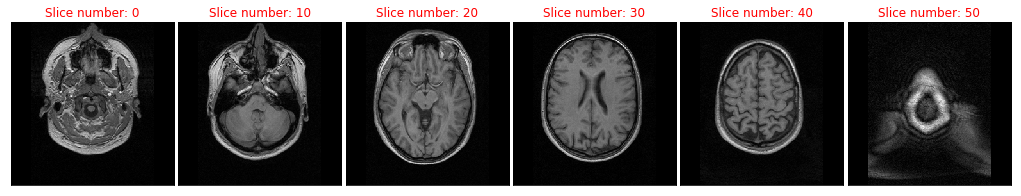

In [3]:
# After downloading the data and moving to the right space
# Find all files in the structural data folder
import os,nibabel
data_path = '../../Dataset/fMRI_data/sM00223/'
files = os.listdir(data_path)

# Read in the data
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()
data = np.rot90(data.squeeze(), 1)

fig, ax = plt.subplots(1, 6, figsize=[18, 3])
n = 0; slice = 0
for _ in range(6):
    ax[n].imshow(data[:, :, slice], 'gray')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
    ax[n].set_title('Slice number: {}'.format(slice), color='r')
    n += 1
    slice += 10
    
fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

(256, 256, 54)
(54, 256, 256)


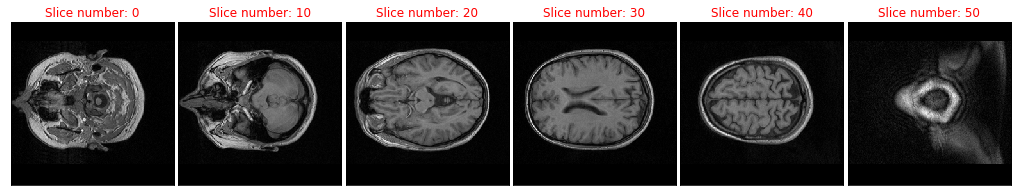

In [4]:
# Transpose the data for better coding
data_reverse = data.T
print(data.shape)
print(data_reverse.shape)
def view_data(data):
    fig, ax = plt.subplots(1, 6, figsize=[18, 3])
    n = 0; slice = 0
    for _ in range(6):
        ax[n].imshow(data[slice, :, :], 'gray')
        ax[n].set_xticks([])
        ax[n].set_yticks([])
        ax[n].set_title('Slice number: {}'.format(slice), color='r')
        n += 1
        slice += 10
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
view_data(data_reverse)

In [5]:
# reshape the data in to a matrix 
data_mat = data_reverse.reshape(54,-1)
print(data_reverse.shape,data_mat.shape)
print('Mean of Mean of each image',data_mat.mean(1).mean())

(54, 256, 256) (54, 65536)
Mean of Mean of each image 29.257389492458767


0.0 29.257389492458767
Before Centering


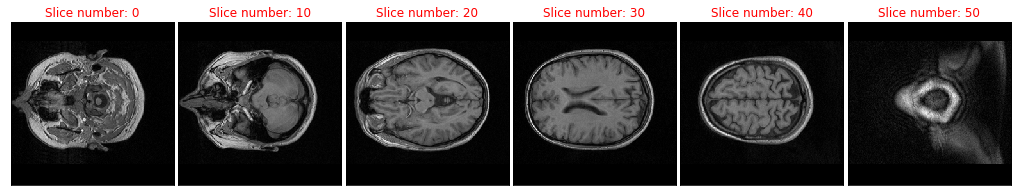

After  Centering


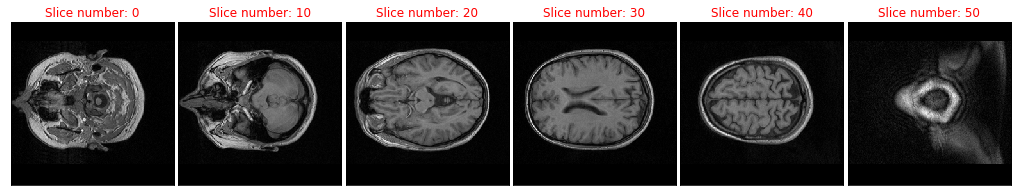

In [6]:
# testing out cernter
def center(X):
    """
     shift the row-wise mean to 0
    """
    centered = X - np.mean(X, axis=1).reshape(len(X), 1)
    return centered
data_centerd = center(data_mat)
print(data_centerd.mean(1).mean(),data_mat.mean(1).mean())
print("Before Centering");view_data(data_mat.reshape(54,256,256))
print("After  Centering");view_data(data_centerd.reshape(54,256,256))

Before white


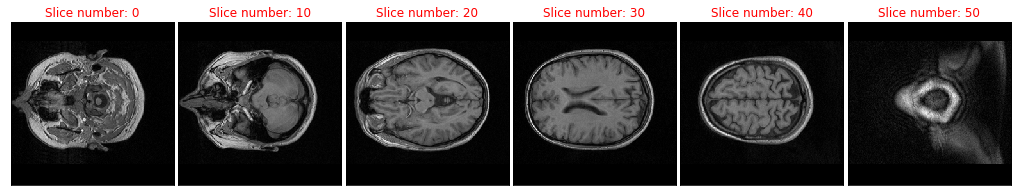

After  white


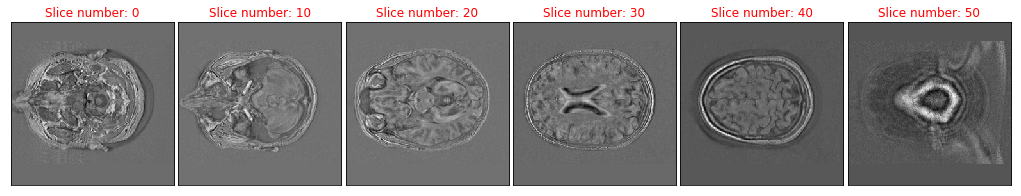

0.09306474530266579 -9.406510174636537 14.965598129128878 0.9956523963676712


In [7]:
# testing out white
def whiten(X, zca=True, red_dim=None):
    if zca:
        # equivalent to taking U instead of V
        Y = np.transpose(X)
        N, p = Y.shape
        Y = Y / np.sqrt(N - 1)
        U, s, V = np.linalg.svd(Y, full_matrices=False)

        if not red_dim:
            S = np.diag(s)
            E = np.transpose(V)
        else:
            order_eigen = np.argsort(-s)
            s_ordered_red = s[order_eigen][:red_dim]
            S = np.diag(s_ordered_red)
            V_ordered_red = V[order_eigen][:red_dim]
            E = np.transpose(V_ordered_red)

        R = np.dot(E, np.dot(np.linalg.inv(S), np.transpose(E)))
        R_inv = np.linalg.inv(R)
        X_whitened = np.dot(R, X)

    else:
        X_t = X
        covarianceMatrix = X_t.dot(X_t.T) / X.shape[1]
        s, E = np.linalg.eig(covarianceMatrix)
        s = s.real
        E = E.real
        order_eigen = np.argsort(-s)
        s_ord_red = s[order_eigen][:red_dim]
        E_ord_red = (E.T[order_eigen][:red_dim]).T
        E = E_ord_red
        S = (np.diag(s_ord_red ** (-0.5)))
        R = np.dot(S, E.T)
        R_inv = np.dot(E, S)
        X_whitened = np.dot(R, X_t)

    return X_whitened, R, R_inv
data_white = whiten(data_mat)
print("Before white");view_data(data_mat.reshape(54,256,256))
print("After  white");view_data(data_white[0].reshape(54,256,256))
print(data_white[0].mean(),data_white[0].min(),data_white[0].max(),data_white[0].std())

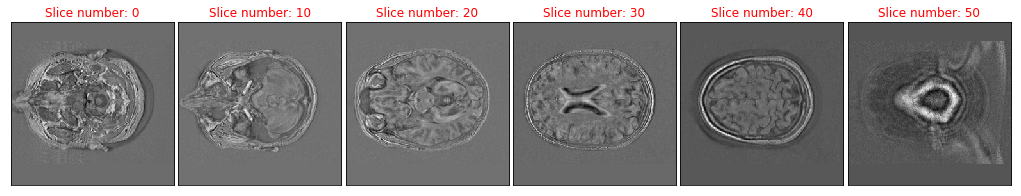

0.0026714399795974147 -0.2700155388304097 0.4295901421179534 0.028580378195720353


In [8]:
# review my zca whitening
def my_zca(x):
    x_cov = x @ x.T / x.shape[0]
    s, E = np.linalg.eigh(x_cov)
    U = E @ np.diag(s ** -0.5) @ E.T
    whiten = U @ x
    return whiten
    
data_my_zca = my_zca(data_mat)
view_data(data_my_zca.reshape(54,256,256))
print(data_my_zca.mean(),data_my_zca.min(),data_my_zca.max(),data_my_zca.std())

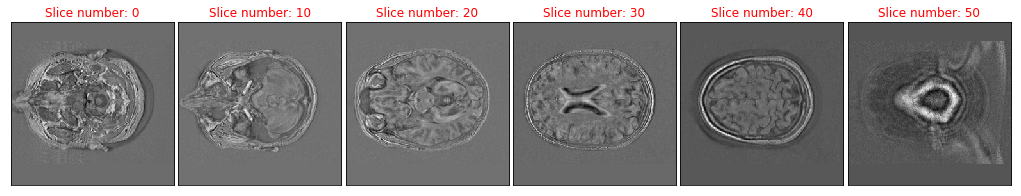

0.0003635369349157607 -0.03674446070844091 0.05845981370614967 0.003889296846379675


In [9]:
# different people white https://gist.github.com/iborko/5d9c2c16004ce8b926ea
def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-matrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert(X.ndim == 2)
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1. / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white
data_other_zca = zca_whiten(data_mat.T).T
view_data(data_other_zca.reshape(54,256,256))
print(data_other_zca.mean(),data_other_zca.min(),data_other_zca.max(),data_other_zca.std())

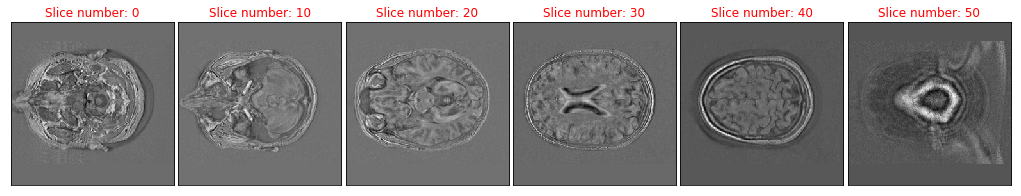

0.0930647453026656 -9.40651017463659 14.965598129128912 0.9956523963676716


In [12]:
# final check with whitening https://github.com/mwv/zca/blob/master/zca/zca.py
def other_zca(data):
    cov = np.dot(data.T, data) / (data.shape[0]-1)
    U, S, _ = np.linalg.svd(cov)
    s = np.sqrt(S.clip(1e-6))
    s_inv = np.diag(1./s)
    s = np.diag(s)
    whiten_ = np.dot(np.dot(U, s_inv), U.T)
    return data @ whiten_.T

data_other_zca = other_zca(data_mat.T).T
view_data(data_other_zca.reshape(54,256,256))
print(data_other_zca.mean(),data_other_zca.min(),data_other_zca.max(),data_other_zca.std())

In [15]:
! git add . 
! git commit -m 'from mac'
! git push 

[master 1503f5de] from mac
 1 file changed, 8 insertions(+), 8 deletions(-)
Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 636 bytes | 636.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   fc0f2981..1503f5de  master -> master
